# HomeWork FRA502 Optimization
Implement Optimization on Rastrigin function to find the global minimum.

In [599]:
# Imports
import numpy as np 
import scipy 
import matplotlib.pyplot as plt 

## Table of content:

1. [Rastrigin Function](#rastrigin-function)
   - Objective function definition
   - Contour and 3D surface visualization

2. [Newton's Method](#newtons-method)
   - Gradient and Hessian computation
   - Finite difference verification
   - Basic Newton step implementation
   - Optimization results and limitations

3. [Damped Newton's Method](#try-to-add-damping)
   - Positive definiteness check
   - Damped step implementation
   - Results and analysis

4. [Armijo Line Search](#try-to-use-line-search-lets-use-armijo-backtracking-line-search)
   - Armijo backtracking implementation
   - Combined damping and line search
   - Convergence analysis

5. [Cross Entropy Method (CEM)](#cross-entropy-method)
   - **Multivariate Gaussian Distribution**
   - **Step 1**: Initialize sampling distribution
   - **Step 2**: Evaluate population fitness
   - **Step 3**: Select elite individuals
   - **Step 4**: Compute sample mean and variance
   - **Step 5**: Update distribution parameters
   - Complete CEM function implementation
   - Testing and visualization
   - Convergence history analysis

## Rastrigin function
Initial rastrigin function to rady for optimization.
in this homework try to solve with this define function

$f(x) = 10d + \sum_{i=1}^{d} (x_i^2 - 10\cos(2\pi x_i))$

where:
- x is a numpy array of shape (d, 1)
- A = 10
- d is the dimension of x
- $x_i$ is the i-th element of x

80


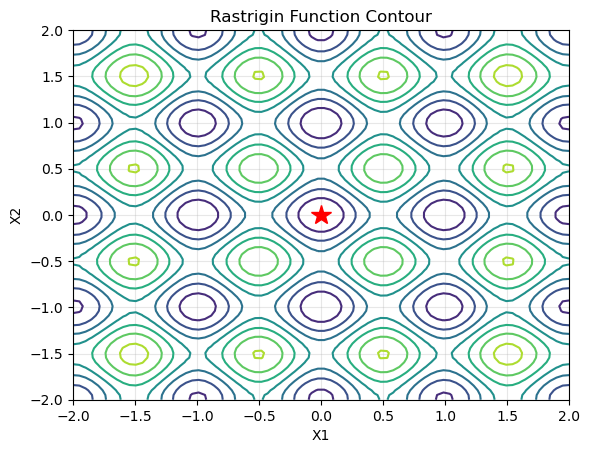

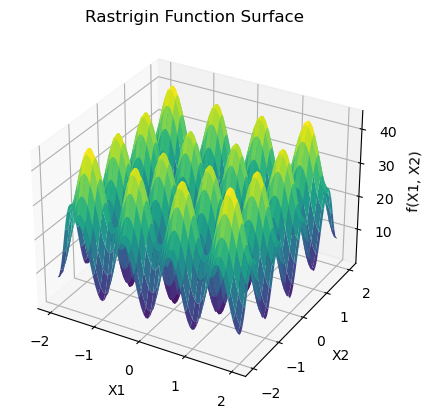

In [600]:
# Rastrigin function
# x is a numpy array of shape (d, 1)
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


# Try to 3d plot
fig3d = plt.figure()
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.plot_surface(X, Y, val, cmap='viridis', edgecolor='none')
ax3d.set_title('Rastrigin Function Surface')
ax3d.set_xlabel('X1')
ax3d.set_ylabel('X2')
ax3d.set_zlabel('f(X1, X2)')
plt.show()

### Newton's Method

Let's remember the Newton's method for **root finding**:

1) We first linearize around the current estimate $\boldsymbol{x}_k$:

$f(\boldsymbol{x}_k + \Delta\boldsymbol{x})\approx f(\boldsymbol{x}_k) + \frac{\partial f}{\partial\boldsymbol{x}}\Big|_{\boldsymbol{x}_k}\Delta\boldsymbol{x}$

2) We then set $f(\boldsymbol{x}_k + \Delta\boldsymbol{x}) = 0$ and solve for $\Delta\boldsymbol{x}$:

$f(\boldsymbol{x}_k) + \frac{\partial f}{\partial\boldsymbol{x}}\Big|_{\boldsymbol{x}_k}\Delta\boldsymbol{x} = 0$

$\Delta\boldsymbol{x} = -\Big(\frac{\partial f}{\partial\boldsymbol{x}}\Big|_{\boldsymbol{x}_k}\Big)^{-1}f(\boldsymbol{x}_k)$

3) We apply the correction $\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \Delta\boldsymbol{x}$

4) Repeat until convergence

Let's try the newton method on our `restrigin function`!


## Objective Function
Base from objective function of restrigin function:
$$f(x) = 10d + \sum_{i=1}^{d} (x_i^2 - 10\cos(2\pi x_i))$$
We need to find the gradient and hessian matrix of the function.
### Gradient
The gradient of the function is given by:
$$\nabla f(x) = 2x + 20\pi \sin(2\pi x)$$
### Hessian Matrix
The Hessian matrix of the function is given by:
$$H(x) = diag(2 + 40\pi^2 \cos(2\pi x_i))$$
where $diag$ denotes a diagonal matrix with the specified elements on the diagonal.

In [601]:
# ความชัน
def gradient_f(x):
    A = 10.
    return 2 * x + A * 2 * np.pi * np.sin(2 * np.pi * x)

# Hessian matrix หรือความโค้ง
def hessian_f(x):
    A = 10.
    diagonal_elements = 2 + 4 * (np.pi**2) * A * np.cos(2 * np.pi * x.T)
    return np.diag(diagonal_elements.flatten())

## Let's test the gradient and Hessian functions

Before implementing Newton's method, we need to ensure that our gradient and Hessian functions are correct.  
We’ll use a finite-difference (FD) method to verify them.

Finite differences approximate derivatives numerically:

### Gradient (first derivative)
For a scalar function $f:\mathbb{R}^d \to \mathbb{R}$ and unit basis $e_i$,
$$
\nabla f(x) \;\approx\;
\begin{bmatrix}
\frac{f(x+\varepsilon e_1)-f(x-\varepsilon e_1)}{2\varepsilon}\\[6pt]
\vdots\\[2pt]
\frac{f(x+\varepsilon e_d)-f(x-\varepsilon e_d)}{2\varepsilon}
\end{bmatrix}.
$$

### Hessian (second derivatives)
Differentiate the gradient components with the same central difference:
$$
\left[\nabla^2 f(x)\right]_{:,i}
\;\approx\;
\frac{\nabla f(x+\varepsilon e_i)-\nabla f(x-\varepsilon e_i)}{2\varepsilon},
\quad i=1,\dots,d.
$$




## Let's start optimization with Newton's Method
Now that we have verified our gradient and Hessian functions, we can implement Newton's method to find the minimum of the Rastrigin function.

Initial value: 14.580169943749475


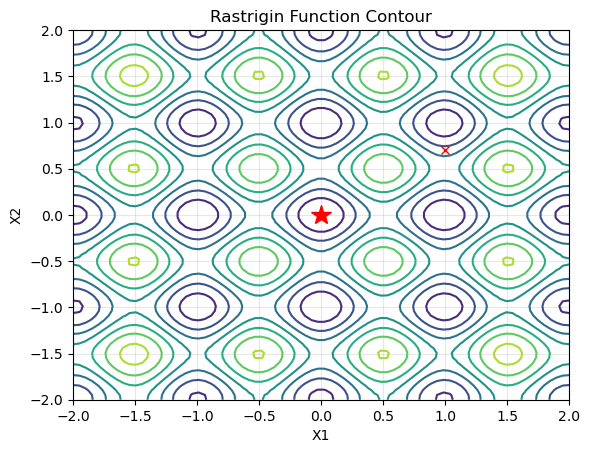

In [602]:
# Initial point
x0 = np.array([[1., 0.7]]).T


ax.plot(x0[0, 0], x0[1, 0], 'rx')

print("Initial value:", f(x0))

fig # show figure again with updated point(s)

In [603]:
def newton_step(x):
    grad = gradient_f(x) 
    hessian = hessian_f(x)
    # dx = -np.linalg.inv(hessian) @ grad
    dx = -np.linalg.solve(hessian, grad)
    return x + dx

## Test Newton's Method
We can now test our Newton's method implementation on the Rastrigin function. We'll start from a random initial point and iterate until convergence.

In [604]:
np.random.seed(10)


x = np.random.randn(2, 1)
print(f"Starting point x: {x.T}")
xn = newton_step(x)
print(f"After Newton step: {xn.T}")
print(f"Expected: [[1.63122303, -0.0027116]]")
assert(np.isclose(xn, np.array([[1.63122303, -0.0027116]]).T, rtol=1e-3, atol=1e-3).all())



x = np.random.randn(2, 1)
print(f"Starting point x: {x.T}")
xn = newton_step(x)
print(f"After Newton step: {xn.T}")
print(f"Expected: [[-1.50668149, 0.]]")
assert(np.isclose(xn, np.array([[-1.50668149, 0.]]).T, rtol=1e-3, atol=1e-3).all())



x = np.random.randn(2, 1)
print(f"Starting point x: {x.T}")
xn = newton_step(x)
print(f"After Newton step: {xn.T}")
print(f"Expected: [[0.47265641, 0.11992915]]")
assert(np.isclose(xn, np.array([[0.47265641, 0.11992915]]).T, rtol=1e-3, atol=1e-3).all())


np.random.seed(None)

Starting point x: [[1.3315865  0.71527897]]
After Newton step: [[ 1.63122303 -0.0027116 ]]
Expected: [[1.63122303, -0.0027116]]
Starting point x: [[-1.54540029 -0.00838385]]
After Newton step: [[-1.50668149e+00  7.72420239e-06]]
Expected: [[-1.50668149, 0.]]
Starting point x: [[ 0.62133597 -0.72008556]]
After Newton step: [[0.47265641 0.11992915]]
Expected: [[0.47265641, 0.11992915]]


## Let's start optimization with Newton's Method
Now that we have verified our newton's method is working, we can implement Newton's method to find the minimum of the Rastrigin function.

In [605]:
# Let's start solving
x = np.copy(x0)

## Now let's see the result of optimization!

step  1 | x = [0.99495948 0.21367445] -> f = 8.777979
step  2 | x = [ 0.99495864 -0.46116288] -> f = 20.911374
step  3 | x = [ 0.99495864 -0.50341789] -> f = 21.246083
step  4 | x = [ 0.99495864 -0.50254599] -> f = 21.246232
step  5 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  6 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  7 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  8 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  9 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 10 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 11 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 12 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 13 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 14 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 15 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 16 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 17 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 18 | x = [ 0.99495864 -0.5025

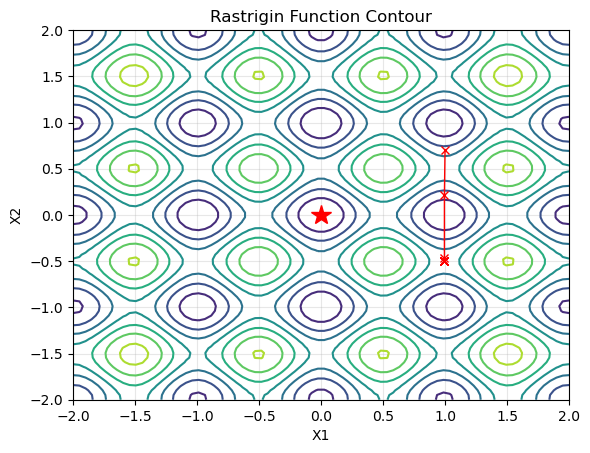

In [606]:

iterations = 20
px, py = [x[0,0]], [x[1,0]]  # to draw a path

for it in range(1, iterations + 1):
    x = newton_step(x)             # one Newton step (no damping/Armijo)
    fx = float(f(x))        # your scalar objective
    print(f"step {it:2d} | x = {x.ravel()} -> f = {fx:.6f}")

    # plot the new point and a short segment from the previous point
    ax.plot(x[0,0], x[1,0], 'rx', ms=6, label=None)
    ax.plot([px[-1], x[0,0]], [py[-1], x[1,0]], 'r-', lw=1)
    px.append(x[0,0]); py.append(x[1,0])

fig

As you can see in this case I have set init point at `x0 = np.array([[1., 0.7]]).T
` or (1.0, 0.7) and I have implement newton's method to optimize the function. After 20 iterations, this can see around step 2-3 that result is around 20-21 whcih mean at this point we found a local maximum or mean the hessian is not Positive definite and the optimization is not converging to the global minimum at (0,0) with f(0,0)=0.

## Try to add damping
This will help to ensure that the Hessian is positive definite and improve convergence.

$\boldsymbol{H} = \nabla^2_{\boldsymbol{x}}f(\boldsymbol{x}_k)$

$\text{while } \boldsymbol{H}\preceq 0:$

$\quad\boldsymbol{H} = \boldsymbol{H} + \beta\boldsymbol{I}$

$\Delta\boldsymbol{x} = -\boldsymbol{H}^{-1}\nabla_{\boldsymbol{x}}f(\boldsymbol{x}_k)$

$\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \Delta\boldsymbol{x}$

In [607]:
def is_pos_def(x):
    """ Check if matrix is positive definite """
    return np.all(np.linalg.eigvals(x) > 0)

def damped_newton_step(x, beta = 100.):
    """ Damped Newton step with damping factor `beta` """
    grad = gradient_f(x) 
    hessian = hessian_f(x)
    d = hessian.shape[0]
    I = np.eye(d)
    while not is_pos_def(hessian):
        hessian += beta * I

    dx = -np.linalg.solve(hessian, grad)
    return x + dx
    

## Re-plot Rastrigin Function

80


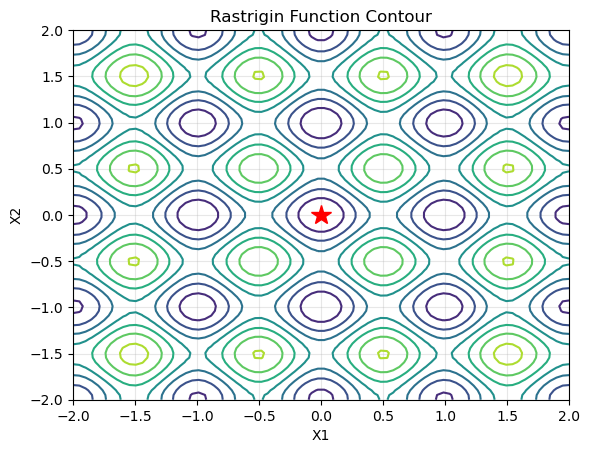

In [608]:
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


Initial value: 14.580169943749475


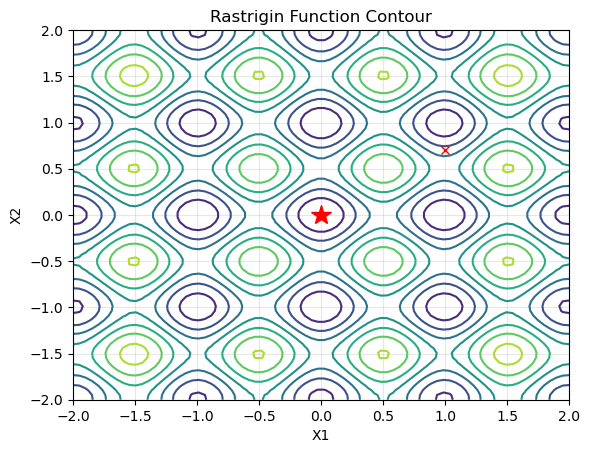

In [609]:
# Initial point
x0 = np.array([[1., 0.7]]).T


ax.plot(x0[0, 0], x0[1, 0], 'rx')

print("Initial value:", f(x0))

fig # show figure again with updated point(s)

step  1 | x = [0.9966487  1.42941263] -> f = 22.071241
step  2 | x = [0.99580728 0.77272786] -> f = 10.169025
step  3 | x = [0.9949587  1.81503654] -> f = 10.315731
step  4 | x = [0.99495864 2.1551141 ] -> f = 10.024573
step  5 | x = [0.99495864 1.9033898 ] -> f = 6.404335
step  6 | x = [0.99495864 2.00157601] -> f = 5.001756
step  7 | x = [0.99495864 1.98991841] -> f = 4.974790
step  8 | x = [0.99495864 1.98991223] -> f = 4.974790
step  9 | x = [0.99495864 1.98991223] -> f = 4.974790
step 10 | x = [0.99495864 1.98991223] -> f = 4.974790
step 11 | x = [0.99495864 1.98991223] -> f = 4.974790
step 12 | x = [0.99495864 1.98991223] -> f = 4.974790
step 13 | x = [0.99495864 1.98991223] -> f = 4.974790
step 14 | x = [0.99495864 1.98991223] -> f = 4.974790
step 15 | x = [0.99495864 1.98991223] -> f = 4.974790
step 16 | x = [0.99495864 1.98991223] -> f = 4.974790
step 17 | x = [0.99495864 1.98991223] -> f = 4.974790
step 18 | x = [0.99495864 1.98991223] -> f = 4.974790
step 19 | x = [0.9949586

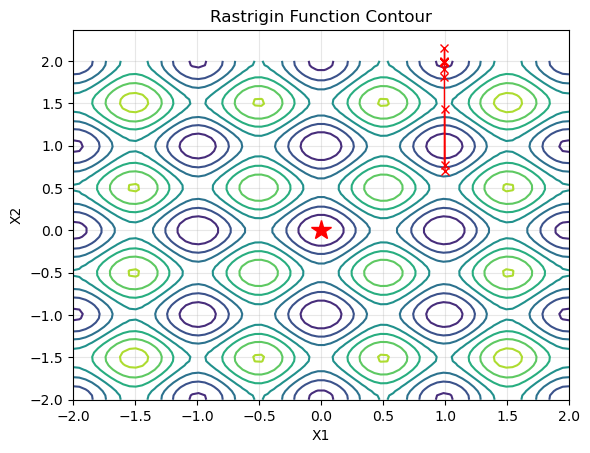

In [610]:
# Let's start solving
x = np.copy(x0)


iterations = 20
px, py = [x[0,0]], [x[1,0]]  # to draw a path

for it in range(1, iterations + 1):
    x = damped_newton_step(x)             # one Newton step (no damping/Armijo)
    fx = float(f(x))        # your scalar objective
    print(f"step {it:2d} | x = {x.ravel()} -> f = {fx:.6f}")

    # plot the new point and a short segment from the previous point
    ax.plot(x[0,0], x[1,0], 'rx', ms=6, label=None)
    ax.plot([px[-1], x[0,0]], [py[-1], x[1,0]], 'r-', lw=1)
    px.append(x[0,0]); py.append(x[1,0])

fig

Based on the results after adding damping to the Hessian matrix with beta = 100.0 for the around step 1-2, we can see that f is decreasing from around 22 to 10. After that, around step 2-3, it overshoots from 10.169 to 10.316. This makes the results move to another basin and then try to converge with f around 4.974790, which is still a local minimum, not the global minimum.

## Try to use line search let's use Armijo backtracking line search
To improve convergence, we can implement Armijo backtracking line search to find an appropriate step size $\alpha$ at each iteration.

$\alpha = 1$

$\text{while } f(\boldsymbol{x}_k + \alpha\Delta\boldsymbol{x}) > f(\boldsymbol{x}_k) + b\alpha\nabla_{\boldsymbol{x}}f(\boldsymbol{x}_k)^T\Delta\boldsymbol{x}:$

$\quad\alpha = c\alpha$

$\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \alpha\Delta\boldsymbol{x}$

where $0<c<1$ and $b$ is something small.

In [611]:
# implemnt damped _ armijo newton step
def armijo_newton_step(x, beta = 1., b = 0.1, c = 0.5):
    grad = gradient_f(x) 
    hessian = hessian_f(x)

    d = hessian.shape[0]
    I = np.eye(d)

    while not is_pos_def(hessian):
       hessian += beta * I

    dx = -np.linalg.solve(hessian, grad)
    a = 1.0
    fx = f(x)
    gT_dx = (grad.T @ dx).item()

    while f(x + a*dx) > fx + b * a * gT_dx:
        a = c * a
    return x + a * dx

## Re-plot Rastrigin Function

80


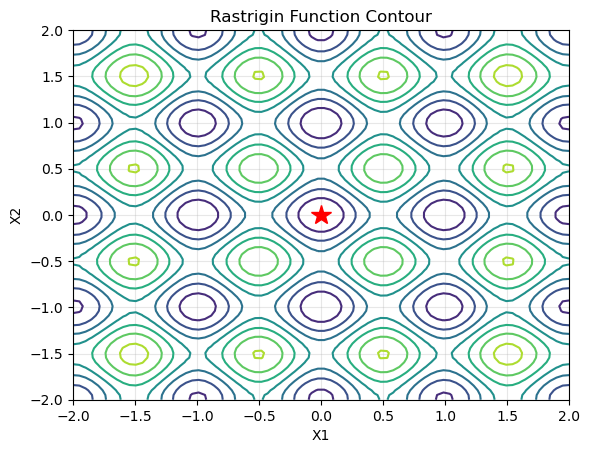

In [612]:
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


Initial value: 14.580169943749475


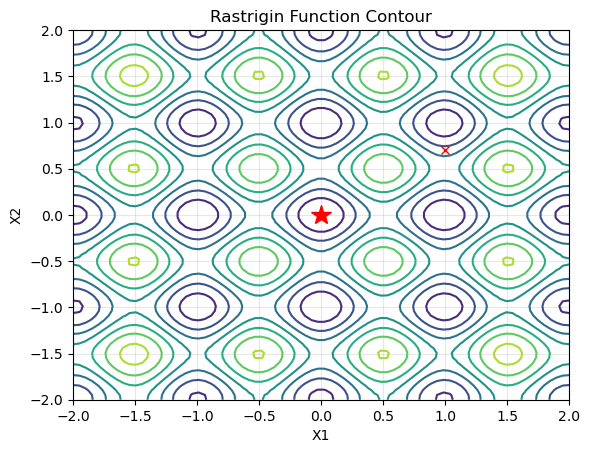

In [613]:
# Initial point
x0 = np.array([[1., 0.7]]).T


ax.plot(x0[0, 0], x0[1, 0], 'rx')

print("Initial value:", f(x0))

fig # show figure again with updated point(s)

step  1 | x = [0.99999988 1.05757579] -> f = 2.765710
step  2 | x = [0.99495948 0.99197633] -> f = 1.991681
step  3 | x = [0.99495864 0.99495987] -> f = 1.989918
step  4 | x = [0.99495864 0.99495864] -> f = 1.989918
step  5 | x = [0.99495864 0.99495864] -> f = 1.989918
step  6 | x = [0.99495864 0.99495864] -> f = 1.989918
step  7 | x = [0.99495864 0.99495864] -> f = 1.989918
step  8 | x = [0.99495864 0.99495864] -> f = 1.989918
step  9 | x = [0.99495864 0.99495864] -> f = 1.989918
step 10 | x = [0.99495864 0.99495864] -> f = 1.989918
step 11 | x = [0.99495864 0.99495864] -> f = 1.989918
step 12 | x = [0.99495864 0.99495864] -> f = 1.989918
step 13 | x = [0.99495864 0.99495864] -> f = 1.989918
step 14 | x = [0.99495864 0.99495864] -> f = 1.989918
step 15 | x = [0.99495864 0.99495864] -> f = 1.989918
step 16 | x = [0.99495864 0.99495864] -> f = 1.989918
step 17 | x = [0.99495864 0.99495864] -> f = 1.989918
step 18 | x = [0.99495864 0.99495864] -> f = 1.989918
step 19 | x = [0.99495864 0.

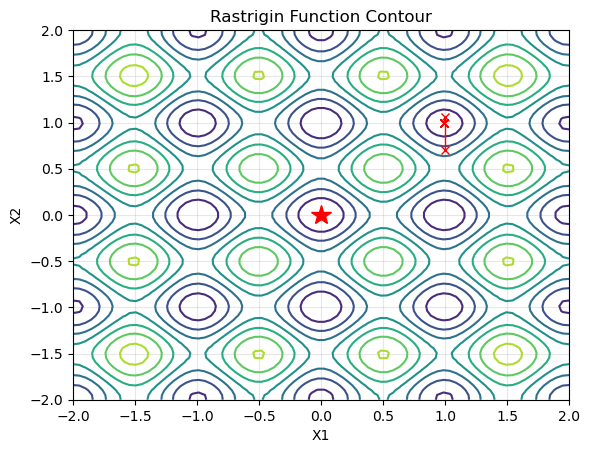

In [614]:
# Let's start solving
x = np.copy(x0)


iterations = 20
px, py = [x[0,0]], [x[1,0]]  # to draw a path

for it in range(1, iterations + 1):
    x = armijo_newton_step(x)             # on e Newton step (no damping/Armijo)
    fx = float(f(x))        # your scalar objective
    print(f"step {it:2d} | x = {x.ravel()} -> f = {fx:.6f}")

    # plot the new point and a short segment from the previous point
    ax.plot(x[0,0], x[1,0], 'rx', ms=6, label=None)
    ax.plot([px[-1], x[0,0]], [py[-1], x[1,0]], 'r-', lw=1)
    px.append(x[0,0]); py.append(x[1,0])

fig

Based on the results after adding Armijo backtracking line search, we can see that the optimization process is more robust and converges more reliably to the minimum. However the results is still stuck at local minimum not the global minimum due to this function having many local minima.

## Cross Entropy Method
Now let's try to implement Cross Entropy Method to find the global minimum of the Rastrigin function.

Let's start how CEM work
First is What is Multivariate Gaussian Distribution
$$\mathcal N(x;\mu,\Sigma)
= \frac{1}{(2\pi)^{d/2}\,|\Sigma|^{1/2}}
\exp\!\left(-\tfrac12 (x-\mu)^{\top}\Sigma^{-1}(x-\mu)\right)$$

Where:
- $x$ is the variable
- $\mu$ is the mean vector
- $\Sigma$ is the covariance matrix
- $d$ is the dimension of $x$

80


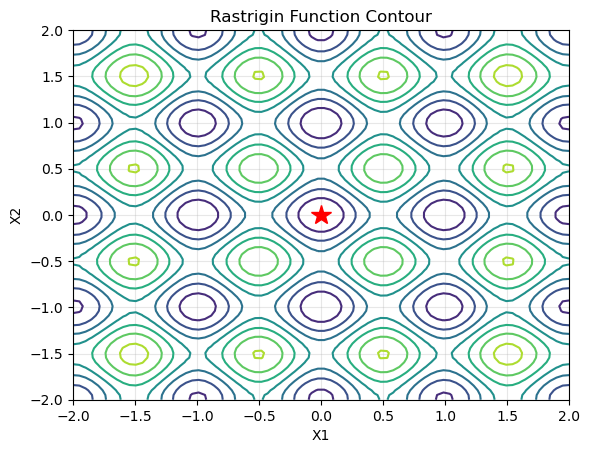

In [615]:
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


### Step 1: Initialize Sampling Distribution

Sample a population of N candidate solutions from a multivariate Gaussian distribution:

$$\mathcal{N}(\boldsymbol{\mu}, \text{diag}(\boldsymbol{\sigma}^2))$$

Where:
- $\boldsymbol{\mu} \in \mathbb{R}^d$ is the mean vector (center of search)
- $\boldsymbol{\sigma}^2 = [\sigma_1^2, \sigma_2^2, \ldots, \sigma_d^2]$ is the variance vector
- $\text{diag}(\boldsymbol{\sigma}^2)$ is the diagonal covariance matrix:
  $$\Sigma = \begin{bmatrix} \sigma_1^2 & 0 & \cdots & 0 \\ 0 & \sigma_2^2 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & \sigma_d^2 \end{bmatrix}$$

**Note:** Using a diagonal covariance assumes independence between dimensions (appropriate for the Rastrigin function).

And then generate a population of size $N,\mathcal{P} = \{x_1, x_2, \ldots, x_N\}$ by sampling from the distribution. where $x_i \sim \mathcal{N}(\boldsymbol{\mu}, \text{diag}(\boldsymbol{\sigma}^2))$

base from below code
- `n_dim`: number of dimensions
- `N`: population size
- `mu_k`: initial mean vector (randomly initialized within bounds)
- `sigma2_k`: initial variance vector (set to a large value for exploration)
- `cov_k`: diagonal covariance matrix constructed from `sigma2_k`
- `distribution`: multivariate normal distribution object from `scipy.stats` initialized with `mu_k` and `cov_k`
- `population`: sampled candidate solutions from the distribution

(-5.471574778846378, 2.725071674214079, -2.7356747682984843, 4.160156188492515)

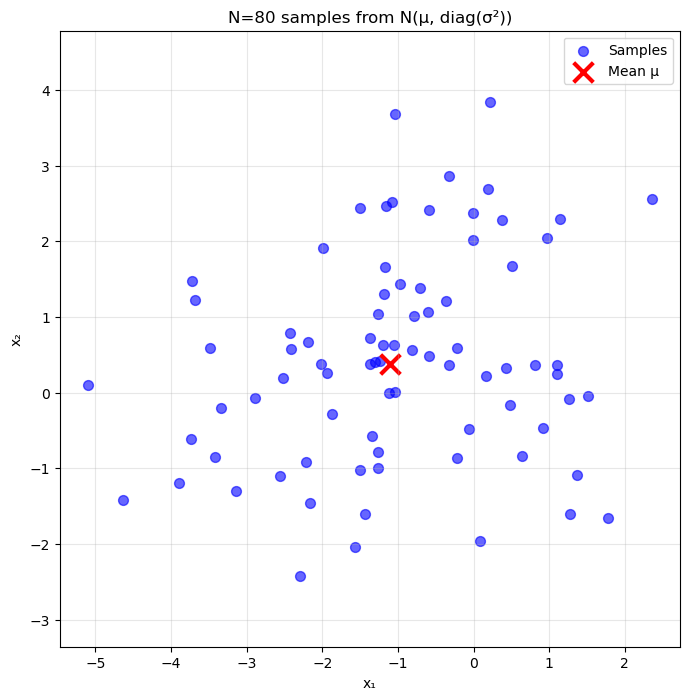

In [616]:
from scipy.stats import multivariate_normal

n_dim = 2           # Number of dimensions
N = 80              # Population size
mu_k = np.random.uniform(-2, 2, n_dim) 
sigma2_k = np.array([2.0, 2.0])  # Large initial variance for exploration
cov_k = np.diag(sigma2_k)


# Create the multivariate normal distribution
distribution = multivariate_normal(mean=mu_k, cov=cov_k)

# Sample N points from this distribution
population = distribution.rvs(size=N)


# Plot
fig_mul_normal = plt.figure(figsize=(8, 8))
ax_mul_normal = fig_mul_normal.add_subplot(1, 1, 1)
ax_mul_normal.scatter(population[:, 0], population[:, 1], 
           c='blue', alpha=0.6, s=50, label='Samples')
ax_mul_normal.scatter(mu_k[0], mu_k[1], 
           c='red', marker='x', s=200, linewidths=3, label='Mean μ')
ax_mul_normal.set_xlabel('x₁')
ax_mul_normal.set_ylabel('x₂')
ax_mul_normal.set_title(f'N={N} samples from N(μ, diag(σ²))')
ax_mul_normal.legend()
ax_mul_normal.grid(True, alpha=0.3)
ax_mul_normal.axis('equal')


### Step 2: Evaluate each individual in the population
base from 
$$\mathcal{F} = \{F(x_1), F(x_2), ..., F(x_N)\}$$
where $F(x_i)$ is the fitness of individual $x_i$ in the population.

Number of fitness values: 80
Best fitness: 1.413799 at index 44
Best position: [-1.04010087  0.00904962]


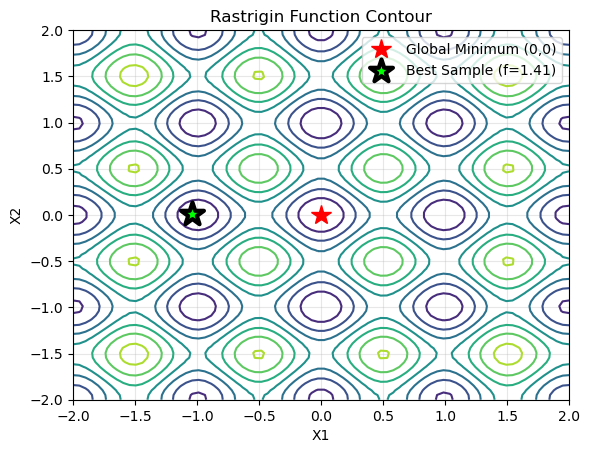

In [617]:
fitness = []
for i in range(N):
    f_xi = f(population[i].reshape(-1, 1))  # ← Add .reshape(-1, 1)
    fitness.append(f_xi)

fitness = np.array(fitness)
print(f"Number of fitness values: {len(fitness)}")
best_idx = np.argmin(fitness)
print(f"Best fitness: {fitness[best_idx]:.6f} at index {best_idx}")
print(f"Best position: {population[best_idx]}")

# Plot the best sample with better visibility
ax.scatter(population[best_idx][0], population[best_idx][1], 
           c='lime', marker='*', s=300, 
           edgecolors='black', linewidth=3, 
           label=f'Best Sample (f={fitness[best_idx]:.2f})', zorder=5)
ax.legend(loc='upper right', fontsize=10)
fig

### Step 3: Select the best M < N individuals
In this step select the best M < N individuals based on their fitness values. 
$$\mathcal{F}:\mathcal{P_{elite}} = \{x_1^{elite}, x_2^{elite}, ..., x_M^{elite}\}$$
where $x_i^{elite}$ is the i-th best individual in the population.

In [618]:
M = 10  # Elite size (M < N)
# Get indices of M best individuals (lowest fitness)
elite_indices = np.argsort(fitness)[:M]

# Extract elite population
elite = population[elite_indices]
elite_fitness = fitness[elite_indices]
print(f"Elite size: {len(elite)}")
best_in_elite = np.argmin(elite_fitness)
print(f"Best fitness in elite: {elite_fitness[best_in_elite]:.6f} at index {elite_indices[best_in_elite]}")
print(f"Best position in elite: {elite[best_in_elite]}")

Elite size: 10
Best fitness in elite: 1.413799 at index 44
Best position in elite: [-1.04010087  0.00904962]


### Step 4: Find Sample Mean and Sample Variance
In this step we calculate the sample mean and the sample (population) variance of the elite individuals to update the parameters of the sampling distribution.

Mean (vector):
$$\boldsymbol{\mu}_{k+1} \;=\; \frac{1}{M}\sum_{i=1}^{M} x_i^{\text{elite}} $$

Variance (per-dimension, population variance as used in code):
$$\boldsymbol{\sigma}^2_{k+1} \;=\; \frac{1}{M}\sum_{i=1}^{M} \big(x_i^{\text{elite}} - \boldsymbol{\mu}_{k+1}\big)^2 $$

Notes:
In code these are computed as:
- `mu_k1 = np.mean(elite_population, axis=0)` (Sample mean)
- `sigma2_k1 = np.var(elite_population, axis=0)`  (Population variance)



μ_old   = [-1.11223505  0.37889431]
μ_new   = [-0.68403923  0.42907629]
σ²_old  = [2. 2.]
σ²_new  = [1.16484046 1.57268286]


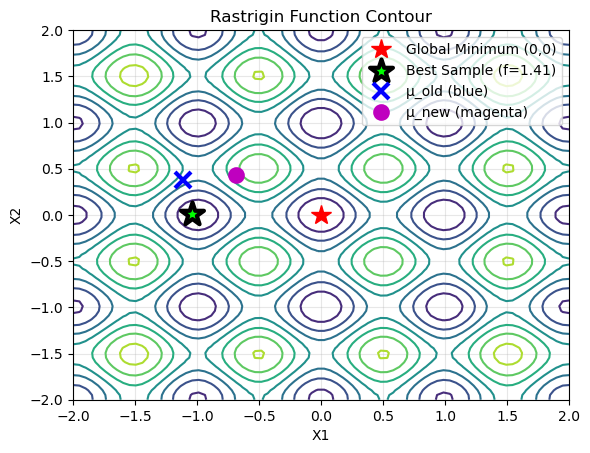

In [619]:
# First init paramters
mu_k_old = mu_k.copy()
sigma2_k_old = sigma2_k.copy()

# Compute new parameters from elite
mu_k1 = np.mean(elite, axis=0)
sigma2_k1 = np.var(elite, axis=0)

# Update with noise
epsilon = 1e-6
mu_k = mu_k1
sigma2_k = sigma2_k1 + epsilon 
cov_k = np.diag(sigma2_k)      

# Print comparison (OLD vs NEW)
print("μ_old   =", mu_k_old)
print("μ_new   =", mu_k)
print("σ²_old  =", sigma2_k_old)
print("σ²_new  =", sigma2_k)

# Visualize
ax.plot(mu_k_old[0], mu_k_old[1], 'bx', ms=12, mew=3, label='μ_old (blue)')
ax.plot(mu_k[0], mu_k[1], 'mo', ms=10, mew=2, label='μ_new (magenta)')
ax.legend(loc='best')
fig

### Step 5: Update the Sampling Distribution
Update the parameters (go back to **step 1**) of the sampling distribution with the new mean and variance and repeat until convergence/stopping criteria 

Now let try implement full function base from step 1-5

In [620]:
def cem(
    n_dim,
    obj_func,
    N=80,
    M=10,
    max_iterations=100,
    init_mu=None,
    init_sigma2=None,
    epsilon=1e-6,
    variance_threshold=1e-8,
    fitness_threshold=1e-3,
    distance_threshold=1e-3,
    target_point=None,
    bounds=(-2, 2),
    verbose=True,
):
    """
    Cross Entropy Method (CEM) optimization

    Parameters
    ----------
    n_dim : int
        Number of dimensions
    obj_func : function
        Objective function to minimize, expects shape (d, 1)
    N : int
        Population size
    M : int
        Elite size (M < N)
    max_iterations : int
        Maximum number of iterations
    init_mu : array-like, optional
        Initial mean vector. If None, randomly initialized
    init_sigma2 : array-like, optional
        Initial variance vector. If None, set to large value
    epsilon : float
        Small noise to prevent variance collapse
    variance_threshold : float
        Stop if variance drops below this
    fitness_threshold : float
        Stop if best fitness is below this
    distance_threshold : float
        Stop if mean is within this distance of target_point
    target_point : array-like, optional
        Known optimum location (defaults to origin)
    bounds : tuple
        (min, max) bounds for initial mean
    verbose : bool
        Print iteration info

    Returns
    -------
    result : dict
        Contains 'x_best', 'f_best', 'iterations', 'mu_history',
        'fitness_history', 'final_variance', 'target_point', 'final_distance'
    """
    
    if init_mu is None:
        mu_k = np.random.uniform(bounds[0], bounds[1], n_dim)
    else:
        mu_k = np.array(init_mu)

    if init_sigma2 is None:
        sigma2_k = np.ones(n_dim) * 2.0  # Large initial variance
    else:
        sigma2_k = np.array(init_sigma2)

    if target_point is None:
        target_point = np.zeros(n_dim)
    else:
        target_point = np.array(target_point)

    mu_history = [mu_k.copy()]
    fitness_history = []
    best_fitness_prev = np.inf

    if verbose:
        print("=" * 60)
        print("Starting Cross Entropy Method (CEM) Optimization")
        print("=" * 60)
        print(f"Dimensions: {n_dim}")
        print(f"Population size: {N}")
        print(f"Elite size: {M}")
        print(f"Initial μ: {mu_k}")
        print(f"Initial σ²: {sigma2_k}")
        print(f"Target point: {target_point}")
        print(f"Distance threshold: {distance_threshold}")
        print("=" * 60)

    for iteration in range(1, max_iterations + 1):
        cov_k = np.diag(sigma2_k)
        distribution = multivariate_normal(mean=mu_k, cov=cov_k)
        population = distribution.rvs(size=N)

        fitness = np.array([obj_func(ind.reshape(-1, 1)) for ind in population])
        best_fitness = np.min(fitness)
        fitness_history.append(best_fitness)

        elite_indices = np.argsort(fitness)[:M]
        elite = population[elite_indices]

        mu_k = np.mean(elite, axis=0)
        sigma2_k = np.var(elite, axis=0) + epsilon

        mu_history.append(mu_k.copy())

        # find distance between mu_k and target_point
        distance = np.linalg.norm(mu_k - target_point)

        if verbose:
            mu_fmt = np.array2string(mu_k, precision=4, separator=', ')
            sigma_fmt = np.array2string(
                sigma2_k,
                precision=2,
                formatter={'float_kind': lambda x: f"{x:.2e}"},
            )
            print(
                f"Iter {iteration:3d} | f_best = {best_fitness:10.6f} | "
                f"μ = {mu_fmt} | σ² = {sigma_fmt} | dist = {distance:.4e}"
            )

        # Check convergence criteria is should smaller then threshold if is optimal
        variance_converged = np.all(sigma2_k < variance_threshold)
        # Check is the best fitness value good enough (if < fitness_threshold mean is close to global minimum)
        fitness_converged = best_fitness < fitness_threshold
        # Check is the mean μ close to the known global minimum
        distance_converged = distance < distance_threshold
        # Check that while iteration is converged or trapped or notting improve 
        no_improvement = abs(best_fitness - best_fitness_prev) < 1e-6

        if (
            variance_converged
            or fitness_converged
            or distance_converged
            or (iteration > 10 and no_improvement)
        ):
            if verbose:
                print("=" * 60)
                print("🎯 CONVERGENCE ACHIEVED!")
                if variance_converged:
                    print("   Reason: Variance collapsed")
                if fitness_converged:
                    print("   Reason: Target fitness reached")
                if distance_converged:
                    print("   Reason: Mean reached target point")
                if iteration > 10 and no_improvement:
                    print("   Reason: No improvement")
            break

        best_fitness_prev = best_fitness

    x_best = mu_k
    f_best = obj_func(x_best.reshape(-1, 1))
    final_distance = np.linalg.norm(x_best - target_point)

    if verbose:
        print("=" * 60)
        print("FINAL RESULTS:")
        print(f"✓ Iterations: {iteration}")
        print(f"✓ Best solution: x* = {x_best}")
        print(f"✓ Best fitness: f(x*) = {f_best:.8f}")
        print(f"✓ Final variance: σ² = {sigma2_k}")
        print(f"✓ Distance to target: {final_distance:.6f}")
        print("=" * 60)

    return {
        'x_best': x_best,
        'f_best': f_best,
        'iterations': iteration,
        'mu_history': np.array(mu_history),
        'fitness_history': np.array(fitness_history),
        'final_variance': sigma2_k,
        'target_point': target_point.copy(),
        'final_distance': final_distance,
    }


## Test the CEM Function
Now let's test our complete CEM implementation on the Rastrigin function and visualize the optimization process.

Starting Cross Entropy Method (CEM) Optimization
Dimensions: 2
Population size: 80
Elite size: 10
Initial μ: [1.50449829 1.63730676]
Initial σ²: [2. 2.]
Target point: [0. 0.]
Distance threshold: 0.001
Iter   1 | f_best =   4.162681 | μ = [1.0634, 1.2145] | σ² = [9.76e-01 7.84e-01] | dist = 1.6142e+00
Iter   2 | f_best =   1.177172 | μ = [0.8923, 0.504 ] | σ² = [1.04e+00 2.55e-01] | dist = 1.0248e+00
Iter   3 | f_best =   1.152469 | μ = [0.3131, 0.3386] | σ² = [1.07e+00 2.40e-01] | dist = 4.6118e-01
Iter   4 | f_best =   1.643651 | μ = [0.2015, 0.1861] | σ² = [5.78e-01 1.65e-01] | dist = 2.7427e-01
Iter   5 | f_best =   0.915843 | μ = [ 0.4419, -0.0101] | σ² = [4.04e-01 5.52e-03] | dist = 4.4200e-01
Iter   6 | f_best =   0.451738 | μ = [ 0.0965, -0.0238] | σ² = [4.63e-01 2.14e-03] | dist = 9.9370e-02
Iter   7 | f_best =   0.015477 | μ = [ 0.2873, -0.0074] | σ² = [2.08e-01 1.27e-03] | dist = 2.8744e-01
Iter   8 | f_best =   0.115354 | μ = [ 0.0985, -0.0183] | σ² = [8.99e-02 3.58e-04] | d

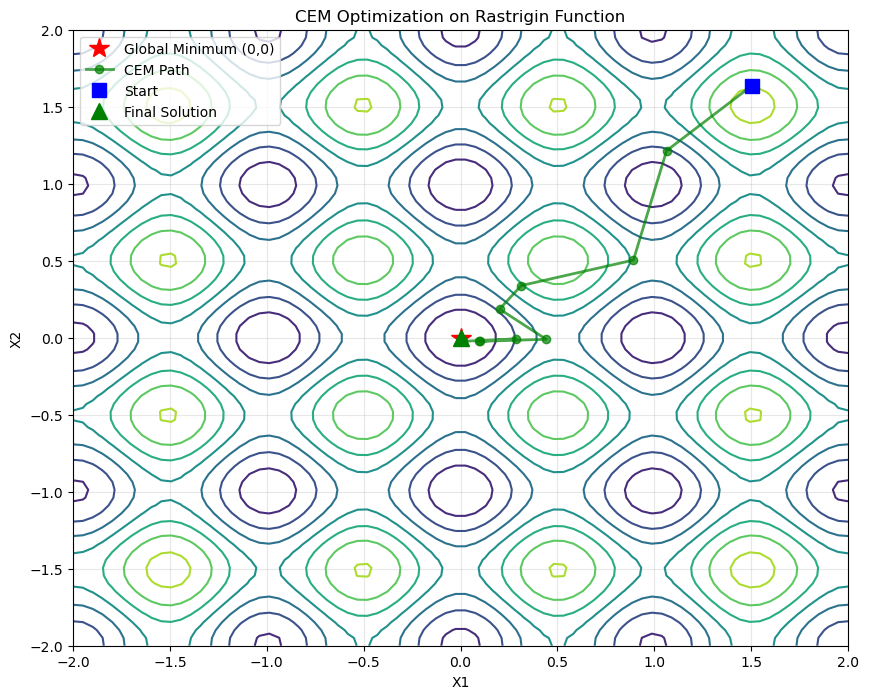

In [621]:
# Re-plot Rastrigin function for visualization
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

plt.close()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

N_plot = 80
x1 = np.linspace(-2., 2., N_plot)
x2 = np.linspace(-2., 2., N_plot)
X, Y = np.meshgrid(x1, x2)
val = np.zeros((N_plot, N_plot))

for i in range(N_plot):
    for j in range(N_plot):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

ax.set_title('CEM Optimization on Rastrigin Function')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N_plot,)), x2.reshape((N_plot,)), val)
ax.grid(True, alpha=0.3)

# Run CEM optimization
result = cem(n_dim=2, obj_func=f, N=80, M=10, max_iterations=100, verbose=True)

# Plot the optimization path
mu_hist = result['mu_history']
ax.plot(mu_hist[:, 0], mu_hist[:, 1], 'go-', linewidth=2, markersize=6, 
        label='CEM Path', alpha=0.7)
ax.plot(mu_hist[0, 0], mu_hist[0, 1], 'bs', markersize=10, label='Start')
ax.plot(mu_hist[-1, 0], mu_hist[-1, 1], 'g^', markersize=12, label='Final Solution')
ax.legend()

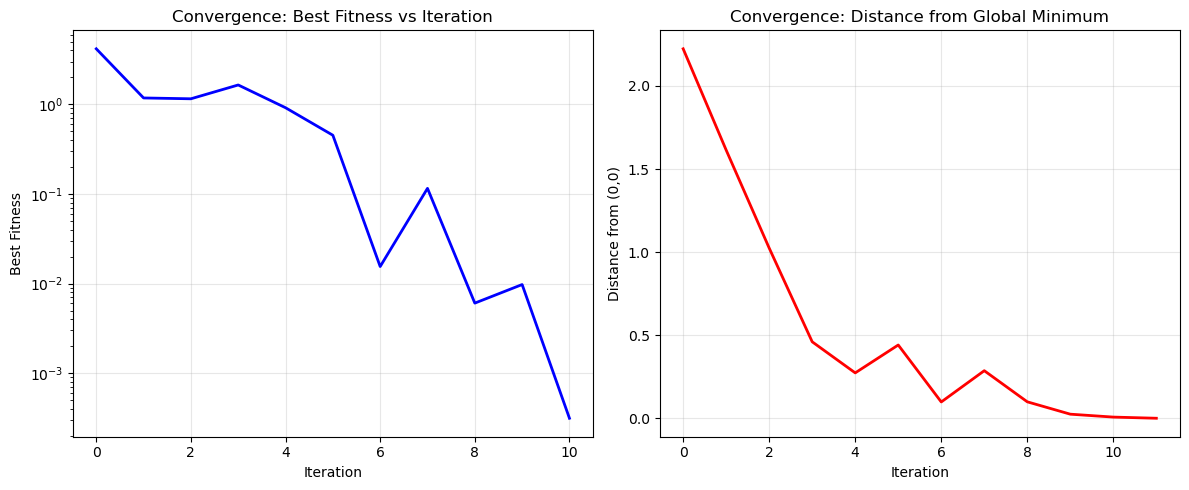

In [622]:
# Plot convergence history
fig_conv = plt.figure(figsize=(12, 5))

# Fitness history
ax1 = fig_conv.add_subplot(1, 2, 1)
ax1.plot(result['fitness_history'], 'b-', linewidth=2)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Best Fitness')
ax1.set_title('Convergence: Best Fitness vs Iteration')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Distance from global minimum
ax2 = fig_conv.add_subplot(1, 2, 2)
distances = np.linalg.norm(result['mu_history'], axis=1)
ax2.plot(distances, 'r-', linewidth=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Distance from (0,0)')
ax2.set_title('Convergence: Distance from Global Minimum')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
